In [ ]:
import pygame
# Definition einiger Farben
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

# Breite und Höhe jedes Grids festlegen
WIDTH = 20
HEIGHT = 20

# Rand zwischen jeder Zelle festlegen
MARGIN = 5

# Set row 1, cell 5 to one. (Remember rows and
# column numbers start at zero.)
grid[1][5] = 1

# Initialize pygame
pygame.init()

# Set the HEIGHT and WIDTH of the screen
WINDOW_SIZE = [255, 255]
screen = pygame.display.set_mode(WINDOW_SIZE)
 
# Set title of screen
pygame.display.set_caption("Array Backed Grid")
 
# Loop until the user clicks the close button.
done = False
 
# Used to manage how fast the screen updates
clock = pygame.time.Clock()

In [ ]:
# -------- Main Program Loop -----------
while not done:
    for event in pygame.event.get():  # User did something
        if event.type == pygame.QUIT:  # If user clicked close
            done = True  # Flag that we are done so we exit this loop
        elif event.type == pygame.MOUSEBUTTONDOWN:
            # User clicks the mouse. Get the position
            pos = pygame.mouse.get_pos()
            # Change the x/y screen coordinates to grid coordinates
            column = pos[0] // (WIDTH + MARGIN)
            row = pos[1] // (HEIGHT + MARGIN)
            # Set that location to one
            grid[row][column] = 1
            print("Click ", pos, "Grid coordinates: ", row, column)
 
    # Set the screen background
    screen.fill(BLACK)
 
    # Draw the grid
    for row in range(10):
        for column in range(10):
            color = WHITE
            if grid[row][column] == 1:
                color = GREEN
            pygame.draw.rect(screen,
                             color,
                             [(MARGIN + WIDTH) * column + MARGIN,
                              (MARGIN + HEIGHT) * row + MARGIN,
                              WIDTH,
                              HEIGHT])
 
    # Limit to 60 frames per second
    clock.tick(60)
 
    # Go ahead and update the screen with what we've drawn.
    pygame.display.flip()
 
# Be IDLE friendly. If you forget this line, the program will 'hang'
# on exit.
pygame.quit()

In [ ]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time

style.use("ggplot")

SIZE = 10

HM_EPISODES = 25000
MOVE_PENALTY = 1
ENEMY_PENALTY = 300
FOOD_REWARD = 25
epsilon = 0.9
EPS_DECAY = 0.9998  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 3000  # how often to play through env visually.

start_q_table = None # None or Filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict!
d = {1: (255, 175, 0),
     2: (0, 255, 0),
     3: (0, 0, 255)}


class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1


if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)


# can look up from Q-table with: print(q_table[((-9, -2), (3, 9))]) for example

episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        #print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q

        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
            env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)

# Test
## Agent für Tutorial Bsp.

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.optimizers import Adam

# für was ist das TensorBoard
from keras.callbacks import TensorBoard

from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2

# andere Variante
#import tensorflow_addons as tfa
#LazyAdam = tfa.optimizers.LazyAdam

Using TensorFlow backend.


In [4]:
# Paar Variablen

DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 100

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False



In [5]:
# Blob Klasse
class Blob:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, size)
        self.y = np.random.randint(0, size)

    def __str__(self):
        return f"Blob ({self.x}, {self.y})"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)

        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)

        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > self.size-1:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        elif self.y > self.size-1:
            self.y = self.size-1



In [6]:
# Blob Umgebung

class BlobEnv:
    SIZE = 10
    RETURN_IMAGES = True
    MOVE_PENALTY = 1
    ENEMY_PENALTY = 300
    FOOD_REWARD = 25
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    ACTION_SPACE_SIZE = 9
    PLAYER_N = 1  # player key in dict
    FOOD_N = 2  # food key in dict
    ENEMY_N = 3  # enemy key in dict
    # the dict! (colors)
    d = {1: (255, 175, 0),
         2: (0, 255, 0),
         3: (0, 0, 255)}

    def reset(self):
        self.player = Blob(self.SIZE)
        self.food = Blob(self.SIZE)
        while self.food == self.player:
            self.food = Blob(self.SIZE)
        self.enemy = Blob(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Blob(self.SIZE)

        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = (self.player-self.food) + (self.player-self.enemy)
        return observation

    def step(self, action):
        self.episode_step += 1
        self.player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if self.RETURN_IMAGES:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player-self.food) + (self.player-self.enemy)

        if self.player == self.enemy:
            reward = -self.ENEMY_PENALTY
        elif self.player == self.food:
            reward = self.FOOD_REWARD
        else:
            reward = -self.MOVE_PENALTY

        done = False
        if reward == self.FOOD_REWARD or reward == -self.ENEMY_PENALTY or self.episode_step >= 200:
            done = True

        return new_observation, reward, done

    def render(self):
        img = self.get_image()
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(1)

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img



In [7]:
env = BlobEnv()

# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
tf.compat.v1.set_random_seed(1)

# Memory fraction, used mostly when trai8ning multiple agents
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=MEMORY_FRACTION)
tf.compat.v1.keras.backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)))

# Create models folder
if not os.path.isdir('models'):
    os.makedirs('models')
    

In [8]:

# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.compat.v1.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)


In [9]:
# Agent class
class DQNAgent:
    def __init__(self):
        
        # Main model
        self.model = self.create_model()
        
        # Ziel-Framework
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0
        
        self.histories = []
        
    def create_model(self):
        model = Sequential()
        
        model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        model.add(Flatten()) # convert 3D Feature map zu 1D Feature Map
        model.add(Dense(64))
        
        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear')) # ACTION_SPACE_SIZE = how many choices (9)
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        
        return model
    
    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        history = self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)
        self.histories.append(history)
        
        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]
    
    
                      
                      
        
        
        

In [10]:
agent = DQNAgent()


# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
        
        
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

W0305 23:30:18.682854  2948 deprecation_wrapper.py:119] From C:\Users\bauer\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0305 23:30:18.687856  2948 deprecation_wrapper.py:119] From C:\Users\bauer\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0305 23:30:18.694857  2948 deprecation_wrapper.py:119] From C:\Users\bauer\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0305 23:30:18.714856  2948 deprecation_wrapper.py:119] From C:\Users\bauer\AppData\Local\Programs\Python\Python36\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. P

In [11]:
print(agent.model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 8, 8, 256)         7168      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 256)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         590080    
_________________________________________________________________
activation_2 (Activation)    (None, 2, 2, 256)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 256)         0         
__________

dict_keys(['loss', 'acc'])


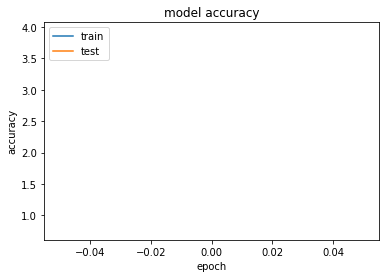

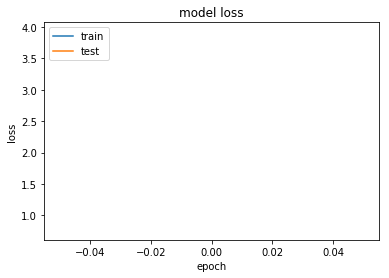

In [26]:
import matplotlib.pyplot as plt
# list all data in history
print(agent.histories[-1].history.keys())
# summarize history for accuracy
plt.plot(agent.histories[-1].history['acc'])
plt.plot(agent.histories[-1].history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(agent.histories[-1].history['loss'])
plt.plot(agent.histories[-1].history['acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()